# THICC: Tennessee's Hottest Industries by County Calculator

This notebook utilizes the Agency for Healthcare Research and Quality (AHRQ)'s Social Determinants of Health (SDOH) Database to train a Random Forest regression model to predict the best Tennessee counties for employment given a user's job industry, education level, and other socioeconomic variables. The user will see the top 5 best Tennessee counties and the overall employment landscape in Tennessee for a given industry.

## Data Preprocessing & Cleaning

This project utilizes AHRQ SDOH data and the U.S. Census Bureau's census tract data. Due to the large file sizes, all spreadsheets, CSVs, and Shapefiles can be found on Harvard Dataverse (https://doi.org/10.7910/DVN/GIOAZY).

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import collections

pd.set_option('display.max_columns', None) 

### Load in AHRQ SDOH data

The original AHRQ SDOH data comes in Excel spreadsheet format. The spreadsheet contains two sheets: LAYOUT and DATA. The LAYOUT sheet contains the column variable names and written descriptions. The DATA sheet contains the data and statistics for those column variable names. 

In [24]:
path = 'data/sdoh_2020_tract_1_0.xlsx'
dfs = pd.read_excel(
        path,
        sheet_name = None,
        dtype = str,
        na_filter = False,
        nrows = 1000,
)

for name, df in dfs.items():
    print(name)
    with pd.option_context('display.max_columns', None):
        display(df.head())

layout_df = dfs['Layout']

Layout


,name,label,type,length,format
0,YEAR,SDOH file year,num,3,4.
1,TRACTFIPS,State-county-census tract FIPS Code (11-digit),char,11,$11.
2,COUNTYFIPS,State-county FIPS Code (5-digit),char,5,$5.
3,STATEFIPS,State FIPS Code (2-digit),char,2,$2.
4,STATE,State name,char,25,$25.


Data


,YEAR,TRACTFIPS,COUNTYFIPS,STATEFIPS,STATE,COUNTY,REGION,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_WORKER_HH,ACS_TOT_WORKER_NWFH,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_FEMALE,ACS_PCT_MALE,ACS_PCT_CTZ_ABOVE18,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_CTZ_US_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VET,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_FEMALE,ACS_MEDIAN_AGE_MALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_EMPLOYED,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_NOT_LABOR,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_UNEMPLOY,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_BELOW137,

Let's look at the LAYOUT sheet and identify non-number data types of the columns.

In [25]:
nonnumerics = []
for name, row in layout_df.iterrows():
    if row['type'] != 'num':
        nonnumerics.append(name)

for idx in nonnumerics:
    col_name = layout_df.loc[idx, 'name']  
    print(f'{col_name!r}: str,')

'TRACTFIPS': str,
'COUNTYFIPS': str,
'STATEFIPS': str,
'STATE': str,
'COUNTY': str,
'REGION': str,
'CEN_AIAN_NH_IND': str,


Now we know to identify some of the columns as strings instead of numbers. Reading the entire DATA sheet as an Excel spreadsheet takes on average 3 minutes. To speed up the process, let's use the CSV version of the DATA sheet instead.

In [26]:
path = 'data/sdoh_2020_tract_1_0_data.csv'
data_df = pd.read_csv(
    path,
    dtype = collections.defaultdict(lambda: float) | {
        'TRACTFIPS': str,
        'COUNTYFIPS': str,
        'STATEFIPS': str,
        'STATE': str,
        'COUNTY': str,
        'REGION': str,
        'CEN_AIAN_NH_IND': str,
    },
    na_filter = True,
    na_values=['', ' '],
)
display(data_df.head())

,YEAR,TRACTFIPS,COUNTYFIPS,STATEFIPS,STATE,COUNTY,REGION,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_WORKER_HH,ACS_TOT_WORKER_NWFH,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_FEMALE,ACS_PCT_MALE,ACS_PCT_CTZ_ABOVE18,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_CTZ_US_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VET,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_FEMALE,ACS_MEDIAN_AGE_MALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_EMPLOYED,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_NOT_LABOR,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_UNEMPLOY,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_BELOW137,

Let's print out some information on the data in our DataFrame.

In [27]:
data_df.info()
data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85528 entries, 0 to 85527
Columns: 329 entries, YEAR to CEN_AIAN_NH_IND
dtypes: float64(322), object(7)
memory usage: 214.7+ MB


,YEAR,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_WORKER_HH,ACS_TOT_WORKER_NWFH,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_FEMALE,ACS_PCT_MALE,ACS_PCT_CTZ_ABOVE18,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_CTZ_US_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VET,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_FEMALE,ACS_MEDIAN_AGE_MALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_EMPLOYED,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_NOT_LABOR,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_UNEMPLOY,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_BELOW137,ACS_PCT_HEALTH_INC_138_199,ACS_PCT_HEALTH_INC_200_3

### Merge AHRQ SDOH DataFrame with TN Census Tract shapefile
The U.S. Census Bureau has a Census Tract shapefile for Tennessee in 2020, so we can give the Tennessee counties a geometry to plot.
Let's merge our AHRQ DataFrame with the Census Tract GeoPandas GeoDataFrame (GDF) by the matching TRACTFIPS and GEOID respectively.

In [28]:
shapefile = gpd.read_file('data/tl_2020_47_tract/tl_2020_47_tract.shp')
display(shapefile.head())

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,175,925200,47175925200,9252,Census Tract 9252,G5020,S,227429512,1667739,+35.7438100,-085.4940227,"POLYGON ((-85.61516 35.76106, -85.61509 35.761..."
1,47,175,925000,47175925000,9250,Census Tract 9250,G5020,S,480712883,1225717,+35.6695378,-085.4220628,"POLYGON ((-85.60513 35.70854, -85.60511 35.708..."
2,47,003,950201,47003950201,9502.01,Census Tract 9502.01,G5020,S,121774227,0,+35.6517480,-086.5575518,"POLYGON ((-86.64406 35.64029, -86.64375 35.642..."
3,47,003,950202,47003950202,9502.02,Census Tract 9502.02,G5020,S,110617191,700793,+35.5845755,-086.5790796,"POLYGON ((-86.66377 35.58189, -86.66367 35.582..."
4,47,093,003300,47093003300,33,Census Tract 33,G5020,S,5860088,229299,+36.0020586,-083.8371218,"POLYGON ((-83.86208 35.99255, -83.86207 35.992..."


In [29]:
merged = data_df.merge(shapefile[['GEOID', 'geometry']], left_on='TRACTFIPS', right_on='GEOID', how='left')

#Reorder the columns to move 'TRACTFIPS' and 'geometry' to the front
columns = ['TRACTFIPS', 'geometry'] + [col for col in merged.columns if col not in ['TRACTFIPS', 'geometry']]
merged = merged[columns]

gdf = gpd.GeoDataFrame(merged, geometry='geometry')
tennessee_gdf = gdf[gdf["TRACTFIPS"].astype(str).str.startswith('47')]
display(tennessee_gdf.head())

,TRACTFIPS,geometry,YEAR,COUNTYFIPS,STATEFIPS,STATE,COUNTY,REGION,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_WORKER_HH,ACS_TOT_WORKER_NWFH,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_FEMALE,ACS_PCT_MALE,ACS_PCT_CTZ_ABOVE18,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_CTZ_US_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VET,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_FEMALE,ACS_MEDIAN_AGE_MALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_EMPLOYED,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_NOT_LABOR,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_UNEMPLOY,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_

Now that the GDF has all the information, let's filter it down to just the columns we need. In particular, we keep columns with county/geographic information, working population, average income, education, and employment in specific industries.

- TRACTFIPS — State-county-census tract FIPS Code (11-digit)
- geometry — Shapely polyon geometry
- COUNTY — County name
- ACS_TOT_CIVILIAN_LABOR — Total population in the civilian labor force (ages 16 and over)
- ACS_TOT_CIVIL_EMPLOY_POP — Total civilian employed population (ages 16 and over)
- ACS_MEDIAN_HH_INC — Median household income (dollars, inflation-adjusted to data file year)
- ACS_MEDIAN_INC_F — Median income of female population (dollars, ages 15 and over with income in the past 12 months, inflation-adjusted to data file year)
- ACS_MEDIAN_INC_M — Median income of male population (dollars, ages 15 and over with income in the past 12 months, inflation-adjusted to data file year)
- ACS_PCT_LT_HS — Percentage of population with less than high school education (ages 25 and over)
- ACS_PCT_HS_GRADUATE — Percentage of population with only high school diploma (ages 25 and over)
- ACS_PCT_COLLEGE_ASSOCIATE_DGR — Percentage of population with some college or associate's degree (ages 25 and over)
- ACS_PCT_BACHELOR_DGR — Percentage of population with a bachelor's degree (ages 25 and over)
- ACS_PCT_GRADUATE_DGR — Percentage of population with a master's or professional school degree or doctorate (ages 25 and over)
- ACS_PCT_POSTHS_ED — Percentage of population with any postsecondary education (ages 25 and over)
- ACS_PCT_ADMIN — Percentage of civilian employed population working in public administration (ages 16 and over)
- ACS_PCT_ARMED_FORCES — Percentage of population in armed forces (ages 16 and over)
- ACS_PCT_ART — Percentage of employed working in arts, entertainment, recreation, and accommodation and food services (ages 16 and over)
- ACS_PCT_CONSTRUCT — Percentage of employed working in construction (ages 16 and over)
- ACS_PCT_EDUC — Percentage of employed working in educational services, and healthcare and social assistance (ages 16 and over)
- ACS_PCT_FINANCE — Percentage of employed working in finance and insurance, real estate, and rental and leasing (ages 16 and over)
- ACS_PCT_GOVT — Percentage of civilian employed population who are government workers (ages 16 and over)
- ACS_PCT_INFORM — Percentage of employed working in information services (ages 16 and over)
- ACS_PCT_MANUFACT — Percentage of employed working in manufacturing (ages 16 and over)
- ACS_PCT_NATURE — Percentage of employed working in agriculture, forestry, fishing and hunting, and mining (ages 16 and over)
- ACS_PCT_OTHER — Percentage of employed working in other services, except public administration (ages 16 and over)
- ACS_PCT_PROFESS — Percentage of employed working in professional, scientific, management, administrative, and waste management services (ages 16 and over)
- ACS_PCT_RETAIL — Percentage of employed working in retail trade (ages 16 and over)
- ACS_PCT_TRANSPORT — Percentage of employed working in transportation and warehousing, and in utilities (ages 16 and over)
- ACS_PCT_WHOLESALE — Percentage of employed working in wholesale trade (ages 16 and over)

In [30]:
filtered_tennessee_gdf = tennessee_gdf[
    [
        'TRACTFIPS',                        #State-county-census tract FIPS Code (11-digit)
        'geometry',                         #Shapely polygon geometry 
        'COUNTY',                           #County name

        'ACS_TOT_CIVILIAN_LABOR',           #Total population in the civilian labor force (ages 16 and over)
        'ACS_TOT_CIVIL_EMPLOY_POP',         #Total civilian employed population (ages 16 and over)

        'ACS_MEDIAN_HH_INC',                #Median household income (dollars, inflation-adjusted to data file year)
        'ACS_MEDIAN_INC_F',                 #Median income of female population (dollars, ages 15 and over with income in the past 12 months, inflation-adjusted to data file year)
        'ACS_MEDIAN_INC_M',                 #Median income of male population (dollars, ages 15 and over with income in the past 12 months, inflation-adjusted to data file year)

        'ACS_PCT_LT_HS',                    #Percentage of population with less than high school education (ages 25 and over)
        'ACS_PCT_HS_GRADUATE',              #Percentage of population with only high school diploma (ages 25 and over)
        'ACS_PCT_COLLEGE_ASSOCIATE_DGR',    #Percentage of population with some college or associate's degree (ages 25 and over)
        'ACS_PCT_BACHELOR_DGR',             #Percentage of population with a bachelor's degree (ages 25 and over)
        'ACS_PCT_GRADUATE_DGR',             #Percentage of population with a master's or professional school degree or doctorate (ages 25 and over)
        'ACS_PCT_POSTHS_ED',                #Percentage of population with any postsecondary education (ages 25 and over)
        
        'ACS_PCT_ADMIN',                    #Percentage of civilian employed population working in public administration (ages 16 and over)
        'ACS_PCT_ARMED_FORCES',             #Percentage of population in armed forces (ages 16 and over)
        'ACS_PCT_ART',                      #Percentage of employed working in arts, entertainment, recreation, and accommodation and food services (ages 16 and over)
        'ACS_PCT_CONSTRUCT',                #Percentage of employed working in construction (ages 16 and over)
        'ACS_PCT_EDUC',                     #Percentage of employed working in educational services, and healthcare and social assistance (ages 16 and over)
        'ACS_PCT_FINANCE',                  #Percentage of employed working in finance and insurance, real estate, and rental and leasing (ages 16 and over)
        'ACS_PCT_GOVT',                     #Percentage of civilian employed population who are government workers (ages 16 and over)
        'ACS_PCT_INFORM',                   #Percentage of employed working in information services (ages 16 and over)
        'ACS_PCT_MANUFACT',                 #Percentage of employed working in manufacturing (ages 16 and over)
        'ACS_PCT_NATURE',                   #Percentage of employed working in agriculture, forestry, fishing and hunting, and mining (ages 16 and over)
        'ACS_PCT_OTHER',                    #Percentage of employed working in other services, except public administration (ages 16 and over)
        'ACS_PCT_PROFESS',                  #Percentage of employed working in professional, scientific, management, administrative, and waste management services (ages 16 and over)
        'ACS_PCT_RETAIL',                   #Percentage of employed working in retail trade (ages 16 and over)
        'ACS_PCT_TRANSPORT',                #Percentage of employed working in transportation and warehousing, and in utilities (ages 16 and over)
        'ACS_PCT_WHOLESALE',                #Percentage of employed working in wholesale trade (ages 16 and over)
    ]
]
filtered_tennessee_gdf = filtered_tennessee_gdf.reset_index(drop=True)
display(filtered_tennessee_gdf.head())

,TRACTFIPS,geometry,COUNTY,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_PCT_LT_HS,ACS_PCT_HS_GRADUATE,ACS_PCT_COLLEGE_ASSOCIATE_DGR,ACS_PCT_BACHELOR_DGR,ACS_PCT_GRADUATE_DGR,ACS_PCT_POSTHS_ED,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_WHOLESALE
0,47001020100,"POLYGON ((-84.32016 35.99186, -84.32008 35.991...",Anderson County,1608.0,1556.0,36130.0,20497.0,33016.0,5.18,25.70,45.58,15.00,8.53,69.12,3.92,0.0,13.17,4.88,20.05,3.60,11.89,0.51,12.40,0.00,1.61,19.47,13.62,6.04,0.71
1,47001020201,"POLYGON ((-84.24333 36.00161, -84.2433 36.0016...",Anderson County,2214.0,2181.0,91078.0,35000.0,70106.0,2.48,14.28,17.80,26.63,38.81,83.24,4.86,0.0,6.42,6.69,27.42,4.08,17.65,0.00,7.66,0.00,4.49,29.48,5.91,1.79,1.19
2,47001020202,"POLYGON ((-84.25132 36.00539, -84.25124 36.005...",Anderson County,1496.0,1489.0,46944.0,28833.0,44384.0,11.08,19.27,26.83,18.37,24.44,69.65,1.48,0.0,4.43,11.28,19.01,6.65,15.45,0.20,5.84,0.00,3.36,24.31,3.22,20.21,0.00
3,47001020300,"POLYGON ((-84.24401 36.04229, -84.2409 36.0440...",Anderson County,1687.0,1652.0,55290.0,25352.0,35750.0,17.47,27.11,34.79,12.63,8.00,55.42,5.69,0.0,9.20,14.71,17.92,1.51,12.17,1.15,9.87,0.48,4.48,19.07,11.44,4.48,0.00
4,47001020400,"POLYGON ((-84.29175 36.02379, -84.29149 36.023...",Anderson County,1951.0,1781.0,49025.0,20638.0,30993.0,11.40,33.02,35.79,12.11,7.68,55.58,1.74,0.0,10.56,13.76,28.13,1.74,4.32,1.29,11.45,0.00,0.95,14.82,11.34,3.37,0.84


Now that we filtered our GDF, let's look at what kind of data we're handling.

In [31]:
filtered_tennessee_gdf.info()
filtered_tennessee_gdf.describe()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   TRACTFIPS                      1701 non-null   object  
 1   geometry                       1701 non-null   geometry
 2   COUNTY                         1701 non-null   object  
 3   ACS_TOT_CIVILIAN_LABOR         1701 non-null   float64 
 4   ACS_TOT_CIVIL_EMPLOY_POP       1701 non-null   float64 
 5   ACS_MEDIAN_HH_INC              1672 non-null   float64 
 6   ACS_MEDIAN_INC_F               1678 non-null   float64 
 7   ACS_MEDIAN_INC_M               1678 non-null   float64 
 8   ACS_PCT_LT_HS                  1685 non-null   float64 
 9   ACS_PCT_HS_GRADUATE            1685 non-null   float64 
 10  ACS_PCT_COLLEGE_ASSOCIATE_DGR  1685 non-null   float64 
 11  ACS_PCT_BACHELOR_DGR           1685 non-null   float64 
 12  ACS_PCT_GRADUATE_DGR      

,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_PCT_LT_HS,ACS_PCT_HS_GRADUATE,ACS_PCT_COLLEGE_ASSOCIATE_DGR,ACS_PCT_BACHELOR_DGR,ACS_PCT_GRADUATE_DGR,ACS_PCT_POSTHS_ED,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_WHOLESALE
count,1701.000000,1701.000000,1672.000000,1678.000000,1678.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1682.000000,1686.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,1954.550852,1850.282187,57817.053828,24397.738379,37121.396901,12.454178,32.581027,28.035733,16.936326,9.992688,54.964736,4.144732,0.379383,9.765826,6.738989,22.319394,5.479768,13.435785,1.528603,13.434982,1.187152,4.836451,9.559596,11.659946,6.959441,2.385541
std,915.754474,889.623948,28024.812360,8357.314852,16773.181267,7.531534,12.436072,7.458725,10.802487,8.618237,17.539556,3.180935,3.183968,6.491690,4.686511,7.376842,3.638671,6.074994,1.885075,7.637369,2.206901,3.827239,5.293470,5.853818,5.303458,2.162742
min,0.000000,0.000000,2499.000000,2499.000000,2620.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1311.000000,1223.000000,40666.250000,18341.000000,26923.500000,6.570000,24.710000,23.510000,8.990000,4.190000,41.600000,1.992500,0.000000,5.510000,3.440000,17.180000,2.822500,9.195000,0.000000,7.762500,0.000000,2.670000,5.805000,8.180000,3.400000,0.750000
50%,1848.000000,1745.000000,51235.000000,22838.500000,33463.500000,11.820000,34.280000,27.730000,13.920000,7.180000,52.180000,3.415000,0.000000,8.570000,5.870000,21.765000,4.880000,12.850000,0.970000,12.025000,0.120000,4.310000,8.760000,10.885000,5.855000,1.950000
75%,2504.000000,2381.000000,68318.500000,28892.000000,42086.250000,17.310000,41.650000,32.560000,22.870000,12.670000,67.010000,5.547500,0.000000,12.655000,9.080000,26.837500,7.580000,16.730000,2.230000,17.995000,1.377500,6.307500,12.370000,14.217500,8.777500,3.480000
max,5983.000000,5746.000000,250001.000000,57841.000000,130885.000000,45.540000,100.000000,89.660000,100.000000,57.140000,100.000000,25.020000,99.030000,100.000000,45.670000,60.970000,25.390000,78.330000,19.270000,47.310000,21.330000,100.000000,39.180000,100.000000,35.260000,16.860000


### Handling empty values
Let's remove empty values and preprocess the data. First, let's check how many empty values there are.

In [32]:
print("GDF shape: ", filtered_tennessee_gdf.shape)
for i in filtered_tennessee_gdf:
    print(f"{i}: {filtered_tennessee_gdf[i].isna().sum()}")

GDF shape:  (1701, 29)
TRACTFIPS: 0
geometry: 0
COUNTY: 0
ACS_TOT_CIVILIAN_LABOR: 0
ACS_TOT_CIVIL_EMPLOY_POP: 0
ACS_MEDIAN_HH_INC: 29
ACS_MEDIAN_INC_F: 23
ACS_MEDIAN_INC_M: 23
ACS_PCT_LT_HS: 16
ACS_PCT_HS_GRADUATE: 16
ACS_PCT_COLLEGE_ASSOCIATE_DGR: 16
ACS_PCT_BACHELOR_DGR: 16
ACS_PCT_GRADUATE_DGR: 16
ACS_PCT_POSTHS_ED: 16
ACS_PCT_ADMIN: 19
ACS_PCT_ARMED_FORCES: 15
ACS_PCT_ART: 19
ACS_PCT_CONSTRUCT: 19
ACS_PCT_EDUC: 19
ACS_PCT_FINANCE: 19
ACS_PCT_GOVT: 19
ACS_PCT_INFORM: 19
ACS_PCT_MANUFACT: 19
ACS_PCT_NATURE: 19
ACS_PCT_OTHER: 19
ACS_PCT_PROFESS: 19
ACS_PCT_RETAIL: 19
ACS_PCT_TRANSPORT: 19
ACS_PCT_WHOLESALE: 19


Dropping any of the rows will lead to missing geometry (empty spaces when we plot). Most likely some census tract areas a part of a county are missing information but not the entire county. Let's fill those empty values with median values calculated from the overall county.

In [33]:
clean_filtered_tennessee_gdf = filtered_tennessee_gdf.copy()

na_row_indices = clean_filtered_tennessee_gdf.index[clean_filtered_tennessee_gdf.isna().any(axis=1)].tolist()
for i in na_row_indices:  
    row = clean_filtered_tennessee_gdf.loc[i]
    missing_cols = row.index[row.isna()].tolist()
    print(f"Row {i} is missing: {missing_cols}")

Row 19 is missing: ['ACS_MEDIAN_HH_INC', 'ACS_MEDIAN_INC_F', 'ACS_MEDIAN_INC_M', 'ACS_PCT_LT_HS', 'ACS_PCT_HS_GRADUATE', 'ACS_PCT_COLLEGE_ASSOCIATE_DGR', 'ACS_PCT_BACHELOR_DGR', 'ACS_PCT_GRADUATE_DGR', 'ACS_PCT_POSTHS_ED', 'ACS_PCT_ADMIN', 'ACS_PCT_ARMED_FORCES', 'ACS_PCT_ART', 'ACS_PCT_CONSTRUCT', 'ACS_PCT_EDUC', 'ACS_PCT_FINANCE', 'ACS_PCT_GOVT', 'ACS_PCT_INFORM', 'ACS_PCT_MANUFACT', 'ACS_PCT_NATURE', 'ACS_PCT_OTHER', 'ACS_PCT_PROFESS', 'ACS_PCT_RETAIL', 'ACS_PCT_TRANSPORT', 'ACS_PCT_WHOLESALE']
Row 68 is missing: ['ACS_MEDIAN_HH_INC', 'ACS_MEDIAN_INC_M', 'ACS_PCT_LT_HS', 'ACS_PCT_HS_GRADUATE', 'ACS_PCT_COLLEGE_ASSOCIATE_DGR', 'ACS_PCT_BACHELOR_DGR', 'ACS_PCT_GRADUATE_DGR', 'ACS_PCT_POSTHS_ED']
Row 69 is missing: ['ACS_MEDIAN_HH_INC', 'ACS_MEDIAN_INC_F', 'ACS_MEDIAN_INC_M', 'ACS_PCT_ADMIN', 'ACS_PCT_ART', 'ACS_PCT_CONSTRUCT', 'ACS_PCT_EDUC', 'ACS_PCT_FINANCE', 'ACS_PCT_GOVT', 'ACS_PCT_INFORM', 'ACS_PCT_MANUFACT', 'ACS_PCT_NATURE', 'ACS_PCT_OTHER', 'ACS_PCT_PROFESS', 'ACS_PCT_RETAIL',

In [34]:
#Calculate county medians and fill missing values
for col in clean_filtered_tennessee_gdf.columns[clean_filtered_tennessee_gdf.isna().any()]:
    clean_filtered_tennessee_gdf[col] = clean_filtered_tennessee_gdf.groupby('COUNTY')[col].transform(lambda x: x.fillna(x.median()))
    

print("Original GDF shape: ", filtered_tennessee_gdf.shape)
print("Cleaned GDF shape: ", clean_filtered_tennessee_gdf.shape)
for i in clean_filtered_tennessee_gdf:
    print(f"{i}: {clean_filtered_tennessee_gdf[i].isna().sum()}")


Original GDF shape:  (1701, 29)
Cleaned GDF shape:  (1701, 29)
TRACTFIPS: 0
geometry: 0
COUNTY: 0
ACS_TOT_CIVILIAN_LABOR: 0
ACS_TOT_CIVIL_EMPLOY_POP: 0
ACS_MEDIAN_HH_INC: 0
ACS_MEDIAN_INC_F: 0
ACS_MEDIAN_INC_M: 0
ACS_PCT_LT_HS: 0
ACS_PCT_HS_GRADUATE: 0
ACS_PCT_COLLEGE_ASSOCIATE_DGR: 0
ACS_PCT_BACHELOR_DGR: 0
ACS_PCT_GRADUATE_DGR: 0
ACS_PCT_POSTHS_ED: 0
ACS_PCT_ADMIN: 0
ACS_PCT_ARMED_FORCES: 0
ACS_PCT_ART: 0
ACS_PCT_CONSTRUCT: 0
ACS_PCT_EDUC: 0
ACS_PCT_FINANCE: 0
ACS_PCT_GOVT: 0
ACS_PCT_INFORM: 0
ACS_PCT_MANUFACT: 0
ACS_PCT_NATURE: 0
ACS_PCT_OTHER: 0
ACS_PCT_PROFESS: 0
ACS_PCT_RETAIL: 0
ACS_PCT_TRANSPORT: 0
ACS_PCT_WHOLESALE: 0


## Create Random Forest model
Now that our data is ready to be used, let's create a regression model. A random forest is an ensemble method that creates multiple decision trees by bootstrapping data samples and using random subsets of features for each tree. The final prediction is made by averaging the outputs of all trees, reducing overfitting and improving accuracy compared to a single decision tree.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [36]:
#Dictionary mappings for industry fields to relevant features
industry_features = {
    'armed forces' : 'ACS_PCT_ARMED_FORCES',
    'arts (entertainment, recreation, accommodation, food services)' : 'ACS_PCT_ART',
    'construction' : 'ACS_PCT_CONSTRUCT',
    'educational services (healthcare, social assistance)' : 'ACS_PCT_EDUC',
    'finance (insurance, real estate, rental/leasing)' : 'ACS_PCT_FINANCE',
    'government' : 'ACS_PCT_GOVT',
    'informaton services' : 'ACS_PCT_INFORM',
    'manufacturing' : 'ACS_PCT_MANUFACT',
    'nature (agriculature, forestry, fishing, hunting, mining)' : 'ACS_PCT_NATURE',
    'other': 'ACS_PCT_OTHER',
    'professional (scientific, management, administrative, waste management)' : 'ACS_PCT_PROFESS',
    'public administration' : 'ACS_PCT_ADMIN',
    'retail' : 'ACS_PCT_RETAIL',
    'transportation (warehousing, utilities)' : 'ACS_PCT_TRANSPORT',
    'wholesale' : 'ACS_PCT_WHOLESALE',
}

#Dictionary mappings for education levels to relevant features
education_features = {
    'less_than_high_school': 'ACS_PCT_LT_HS',
    'high_school': 'ACS_PCT_HS_GRADUATE',
    'some_college/associates': 'ACS_PCT_COLLEGE_ASSOCIATE_DGR',
    'bachelors': 'ACS_PCT_BACHELOR_DGR',
    'masters/doctorate': 'ACS_PCT_GRADUATE_DGR',   
    'postsecondary': 'ACS_PCT_POSTHS_ED'
}


feature_names = [
    'ACS_TOT_CIVILIAN_LABOR',
    'ACS_TOT_CIVIL_EMPLOY_POP',
    'ACS_MEDIAN_HH_INC', 
    'ACS_MEDIAN_INC_F',
    'ACS_MEDIAN_INC_M',
    'ACS_PCT_LT_HS',
    'ACS_PCT_HS_GRADUATE',
    'ACS_PCT_COLLEGE_ASSOCIATE_DGR',
    'ACS_PCT_BACHELOR_DGR',
    'ACS_PCT_GRADUATE_DGR',
    'ACS_PCT_POSTHS_ED',
    'ACS_PCT_ADMIN',
    'ACS_PCT_ARMED_FORCES',
    'ACS_PCT_ART',
    'ACS_PCT_CONSTRUCT',
    'ACS_PCT_EDUC',
    'ACS_PCT_FINANCE',
    'ACS_PCT_GOVT',
    'ACS_PCT_INFORM',
    'ACS_PCT_MANUFACT',
    'ACS_PCT_NATURE',
    'ACS_PCT_OTHER',
    'ACS_PCT_PROFESS',
    'ACS_PCT_RETAIL',
    'ACS_PCT_TRANSPORT',
    'ACS_PCT_WHOLESALE',
]

### Train the RF model
Let's create a function to train a random forest model to predict industry suitability scores for counties. Creating a score that factors in household income, population density, and other variables will make it easier for the regression model to predict and return something more meaningful than looking at those variables individually.

In [37]:
def train_rf_model():
    feature_vectors = []
    labels = []
    df = clean_filtered_tennessee_gdf.copy()

    #Normalize the values - income, population, and percentages are all on different scales
    scaler = MinMaxScaler() 
    df.loc[:, feature_names] = scaler.fit_transform(df[feature_names])

    #Loop through each county to collect all values from features
    for i, county in df.iterrows():
        features = [county.get(f, 0) for f in feature_names]
        feature_vectors.append(features)
        
        #Create a composite target that represents overall industry suitability
        #Add all normalized feature values together so they all have equal weight
        target_score = 0        
        for f in feature_names:
            target_score += county.get(f, 0)
        
        labels.append(target_score)


    #Split the data into training 67% and testing 33%
    X = np.array(feature_vectors)
    y = np.array(labels)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model = RandomForestRegressor(random_state=42)

    #Check model performance with cross-validation
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean R² score: {cv_scores.mean()}")

    #Do the real training/testing split
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Average Error (MAE) score: ", mae)
    print("Mean Squared Error (MSE) score: ", mse)
    print("Mean Absolute Percentage Error (MAPE) score : ", mape)
    print("R² score: ", r2)

    return model

### Predict with RF model
Now that we trained our RF model, let's predict industry suitability scores for all Tennessee counties given user-inputted industry name and education level. We first calculate a base prediction where all industries and education levels have equal weights. In order to highlight specific counties better suited for a particular industry and education level, we recalculate the industry suitability score with 70% base prediction and 30% industry/education factors. The score boosts are calculated by seeing if each row's selected industry/education values are higher or lower than the overall average to create a ratio. A high ratio means that industry/education is more prevalent and a low ratio means it's not. Now the counties that are stronger for the industry and education level will rank higher versus overall good, general suitability scores.

In [38]:
def predict_with_industry_education(model, user_industry, user_education):
    features_matrix = clean_filtered_tennessee_gdf[feature_names].fillna(0).values

    #Calculate base prediction with scores for all industries and education (equal weights)
    base_prediction = model.predict(features_matrix)
    prediction_df = clean_filtered_tennessee_gdf[['TRACTFIPS', 'COUNTY', user_industry, user_education]].copy()
    prediction_df['Industry Suitability Score'] = base_prediction

    #Give score boosts depending on the user's industry
    if user_industry in clean_filtered_tennessee_gdf.columns:
        #Create ratio to see if percentage is above or below average
        career_boost = clean_filtered_tennessee_gdf[user_industry] / clean_filtered_tennessee_gdf[user_industry].mean()
        #The formula gives 70% weight to the original score and 30% to the career-specific boost
        prediction_df['Industry Suitability Score'] *= (0.7 + 0.3 * career_boost.fillna(0))

    #Give score boosts depending on the user's education
    if user_education in clean_filtered_tennessee_gdf.columns:
        education_boost = clean_filtered_tennessee_gdf[user_education] / clean_filtered_tennessee_gdf[user_education].mean()
        prediction_df['Industry Suitability Score'] *= (0.7 + 0.3 * education_boost.fillna(0))


    #Normalize scores to 0-100 range and order by highest score
    min_score = prediction_df['Industry Suitability Score'].min()
    max_score = prediction_df['Industry Suitability Score'].max()
    prediction_df['Industry Suitability Score'] = 100 * (prediction_df['Industry Suitability Score'] - min_score) / (max_score - min_score)
    return prediction_df.sort_values(by='Industry Suitability Score', ascending=False)

## Implementation

### Evaluating the model
Let's look at the model performance and the most important features.

In [39]:
print("Training Random Forest model...")
model = train_rf_model()

Training Random Forest model...
Cross-validation R² scores: [0.93970428 0.91083903 0.91560997 0.91380143 0.89534838]
Mean R² score: 0.9150606191956561
Mean Average Error (MAE) score:  0.15576254316440127
Mean Squared Error (MSE) score:  0.043357923509279174
Mean Absolute Percentage Error (MAPE) score :  0.02727324160662392
R² score:  0.9253812019167187


Feature importances:
2: ACS_MEDIAN_HH_INC - 0.5200
1: ACS_TOT_CIVIL_EMPLOY_POP - 0.1729
3: ACS_MEDIAN_INC_F - 0.0909
4: ACS_MEDIAN_INC_M - 0.0612
0: ACS_TOT_CIVILIAN_LABOR - 0.0300
10: ACS_PCT_POSTHS_ED - 0.0263
6: ACS_PCT_HS_GRADUATE - 0.0120
17: ACS_PCT_GOVT - 0.0114
11: ACS_PCT_ADMIN - 0.0084
23: ACS_PCT_RETAIL - 0.0076
9: ACS_PCT_GRADUATE_DGR - 0.0065
25: ACS_PCT_WHOLESALE - 0.0063
13: ACS_PCT_ART - 0.0063
16: ACS_PCT_FINANCE - 0.0057
8: ACS_PCT_BACHELOR_DGR - 0.0041
7: ACS_PCT_COLLEGE_ASSOCIATE_DGR - 0.0040
15: ACS_PCT_EDUC - 0.0033
5: ACS_PCT_LT_HS - 0.0032
24: ACS_PCT_TRANSPORT - 0.0032
19: ACS_PCT_MANUFACT - 0.0032
18: ACS_PCT_INFORM - 0.0032
21: ACS_PCT_OTHER - 0.0029
14: ACS_PCT_CONSTRUCT - 0.0026
22: ACS_PCT_PROFESS - 0.0021
20: ACS_PCT_NATURE - 0.0013
12: ACS_PCT_ARMED_FORCES - 0.0013


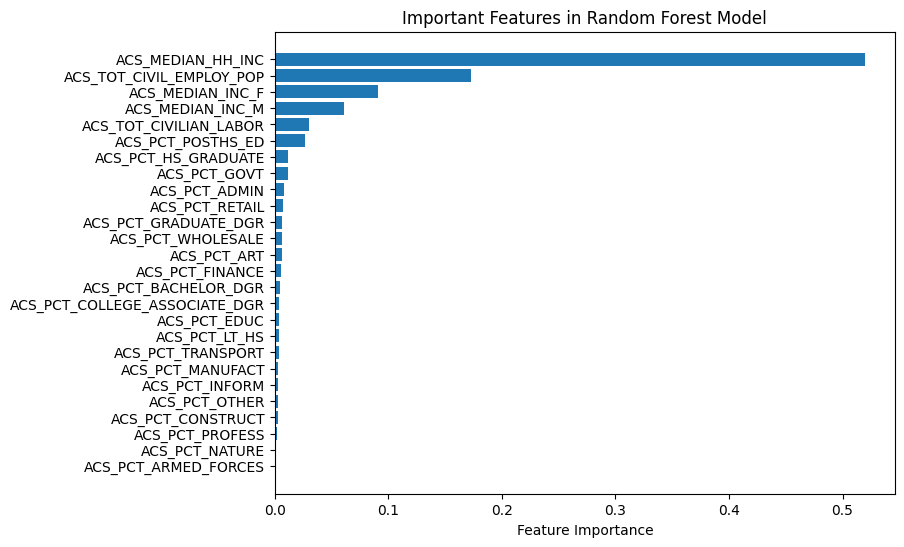

In [40]:
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

print("Feature importances:")
for idx in sorted_indices:
    print(f"{idx}: {feature_names[idx] if idx < len(feature_names) else 'Career Feature'} - {importances[idx]:.4f}")

plt.figure(figsize=(8, 6))
plt.barh([feature_names[idx] if idx < len(feature_names) else f"Career Feature {idx}" for idx in sorted_indices], importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Important Features in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

Model performance is really good with a R² score of 0.9254 and low error rates! It's interesting to note that the most influential features are median household income, total employed civilian population, median incomes for male and females, and total civilian labor population (includes those looking for jobs + employed). Those features make up the socioeconomic state of the county. The most important industry feature is the percentage of government workers. The most important education feature is the percentage of the population with postsecondary education (anything after high school).

### Interactive choropleth plot creation 
Now that our model works well, let's put it to the test! The industry and education level can be interactively changed to quickly see new data plotted. We create a choropleth map to see how the different prediction scores map across the Tennessee counties geographically.  

,TRACTFIPS,COUNTY,ACS_PCT_ARMED_FORCES,ACS_PCT_LT_HS,Industry Suitability Score
1002,47125980100,Montgomery County,99.03,0.00,100.000000
978,47125101400,Montgomery County,53.69,6.43,66.927536
1314,47157020400,Shelby County,39.28,2.17,43.086888
976,47125101308,Montgomery County,20.44,9.46,27.928116
972,47125101304,Montgomery County,18.45,7.86,24.166859


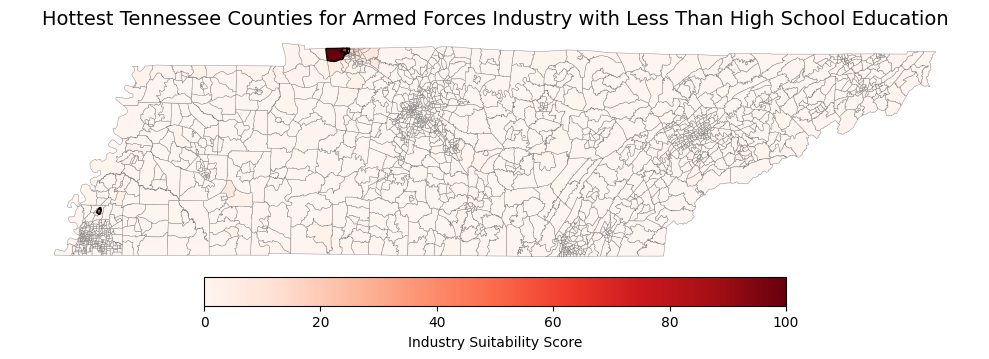

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

#To be interactive, we need to update predictions and plot with the new dropdown values
def update_visualization_static(user_industry, user_education):
    industry_value = industry_features[user_industry]
    education_value = education_features[user_education]
    
    predictions = predict_with_industry_education(model, industry_value, education_value)
    predictions = predictions.sort_values('Industry Suitability Score', ascending=False)
    
    #Clear previous output 
    clear_output(wait=True)
    
    #Show the widgets again
    display(widgets.HBox([industry_dropdown_static, education_dropdown_static]))
    
    #Show the top 5 counties/areas
    print(f'Top 5 Hottest Tennessee Counties for {user_industry.title()} Industry with {user_education.replace("_", " ").title()} Education')
    top_counties = predictions.head(5)
    display(top_counties)


    #Merge predictions with original, big GDF to see all variables
    tn_plot_gdf = pd.merge(
        clean_filtered_tennessee_gdf,
        predictions[['TRACTFIPS', 'COUNTY', 'Industry Suitability Score']],
        on=['TRACTFIPS', 'COUNTY'],
        how='left'
    )


    #Identify top 5 rows
    top_county_geoids = top_counties['TRACTFIPS'].tolist()
    top_5_gdf = tn_plot_gdf[tn_plot_gdf['TRACTFIPS'].isin(top_county_geoids)]
    create_choropleth_plot(tn_plot_gdf, top_5_gdf, user_industry, user_education)


    
def create_choropleth_plot(tn_plot_gdf ,top_5_gdf, user_industry, user_education):
    fig, ax = plt.subplots(figsize=(10, 5))
    #Base map: All counties shaded by predicted score
    tn_plot_gdf.plot(
        column='Industry Suitability Score',
        cmap='Reds',
        edgecolor='gray',  
        linewidth=0.3,      
        legend=True,
        legend_kwds={
            'label': "Industry Suitability Score",
            'orientation': "horizontal",
            'shrink': 0.6,
            'pad': 0.02
        },
        ax=ax
    )
    #Outline the top 5
    top_5_gdf.plot(
        ax=ax,
        facecolor="none",  
        edgecolor="black",  
        linewidth=1        
    )
    plt.title(f'Hottest Tennessee Counties for {user_industry.title()} Industry with {user_education.replace("_", " ").title()} Education', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



#Interactive update function
def on_change_static(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_visualization_static(industry_dropdown_static.value, education_dropdown_static.value)




#Create dropdown widgets
industry_options = list(industry_features.keys())
education_options = list(education_features.keys())

industry_dropdown_static = widgets.Dropdown(
    options=[(industry.title(), industry) for industry in industry_options],
    description='Industry:',
    style={'description_width': 'initial'},
)

education_dropdown_static = widgets.Dropdown(
    options=[(edu_level.replace('_', ' ').title(), edu_level) for edu_level in education_options],
    description='Education:',
    style={'description_width': 'initial'},
)

industry_dropdown_static.observe(on_change_static)
education_dropdown_static.observe(on_change_static)
display(widgets.HBox([industry_dropdown_static, education_dropdown_static]))
update_visualization_static(industry_options[0], education_options[0])

### Interactive map
With our plotting above, we can only see the calculated industry suitability scores. Plus, the census tract areas can be too small to see. Let's create an interactive map with Plotly that can zoom in and display other variable values that contributed to the scores.

In [ ]:
import plotly.express as px


def update_visualization_interactive(user_industry, user_education):
    industry_value = industry_features[user_industry]
    education_value = education_features[user_education]
    
    predictions = predict_with_industry_education(model, industry_value, education_value)
    predictions = predictions.sort_values('Industry Suitability Score', ascending=False)
    
    #Clear previous output 
    clear_output(wait=True)
    
    #Show the widgets again
    display(widgets.HBox([industry_dropdown_interactive, education_dropdown_interactive]))
    
    #Show the top 5 counties/areas
    print(f'Top 5 Hottest Tennessee Counties for {user_industry.title()} Industry with {user_education.replace("_", " ").title()} Education')
    top_counties = predictions.head(5)
    display(top_counties)


    #Merge predictions with original, big GDF to see all variables
    tn_plot_gdf = pd.merge(
        clean_filtered_tennessee_gdf,
        predictions[['TRACTFIPS', 'COUNTY', 'Industry Suitability Score']],
        on=['TRACTFIPS', 'COUNTY'],
        how='left'
    )


    #Identify top 5 rows
    top_county_geoids = top_counties['TRACTFIPS'].tolist()
    top_5_gdf = tn_plot_gdf[tn_plot_gdf['TRACTFIPS'].isin(top_county_geoids)]
    create_interactive_map(tn_plot_gdf, user_industry, user_education)



def create_interactive_map(tn_plot_gdf, user_industry, user_education):
    # Create the figure with hover data
    fig = px.choropleth_map(
        tn_plot_gdf,
        geojson=tn_plot_gdf.geometry.__geo_interface__,
        locations=tn_plot_gdf.index,
        color='Industry Suitability Score',
        color_continuous_scale='Reds',
        hover_data=['TRACTFIPS', 'COUNTY', 
                    'ACS_TOT_CIVIL_EMPLOY_POP', 'ACS_MEDIAN_HH_INC', 
                    industry_features[user_industry], education_features[user_education],
                    'Industry Suitability Score'],
        opacity=0.8,
        center={"lat": 35.86, "lon": -86.36},
        zoom=7,
        map_style="carto-positron",
        labels={'Industry Suitability Score': 'Industry Suitability Score'}
    )

    # Update layout
    fig.update_layout(
        title=f'Hottest Tennessee Counties for {user_industry.title()} Industry with {user_education.replace("_", " ").title()} Education',
        margin={"r": 0, "t": 30, "l": 0, "b": 0},
        height=700,
        coloraxis_colorbar=dict(
            title="Score",
        )
    )

    #Update hover template
    fig.update_traces(
        hovertemplate='<b>TRACTFIPS: %{customdata[0]}</b><br>' +
                    'County: %{customdata[1]}<br>' +
                    'Total Employed Civilian Population: %{customdata[2]}<br>' +
                    'Median Household Income: $%{customdata[3]}<br>' +
                    'Percentage of Industry: %{customdata[4]}%<br>' +
                    'Percentage of Education: %{customdata[5]}%<br>' +
                    'Predicted Score: %{customdata[6]:.2f}<br>'
    )
    fig.show()


def on_change_interactive(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_visualization_interactive(industry_dropdown_interactive.value, education_dropdown_interactive.value)




#Create dropdown widgets
industry_options = list(industry_features.keys())
education_options = list(education_features.keys())

industry_dropdown_interactive = widgets.Dropdown(
    options=[(industry.title(), industry) for industry in industry_options],
    description='Industry:',
    style={'description_width': 'initial'},
)

education_dropdown_interactive = widgets.Dropdown(
    options=[(edu_level.replace('_', ' ').title(), edu_level) for edu_level in education_options],
    description='Education:',
    style={'description_width': 'initial'},
)

industry_dropdown_interactive.observe(on_change_interactive)
education_dropdown_interactive.observe(on_change_interactive)
display(widgets.HBox([industry_dropdown_interactive, education_dropdown_interactive]))
update_visualization_interactive(industry_options[0], education_options[0])